# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [13]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
import torch
import scipy
from scipy.special import inv_boxcox

# File sorting

`*` matches 0 or more characters.

In [14]:
file_list = glob('/nvme0/gfas-frp/FRP_20??_??.nc')

A sample of file names.

In [5]:
file_list[:3]

['/nvme0/gfas-frp/FRP_2020_01.nc',
 '/nvme0/gfas-frp/FRP_2019_08.nc',
 '/nvme0/gfas-frp/FRP_2019_11.nc']

Sorting files by time to get deterministic order after loading.

In [15]:
files = sorted(file_list, key=lambda x: int(x[-8:-6])*100 + int(x[-5:-3]))

*Data is expected to be for 12 months*

In [10]:
len(files)

12

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.

In [20]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-reanalysis')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file.

In [12]:
xr.open_dataset(files[0])

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 30)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.75 359.85 359.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-04-30
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 04:44:57 GMT by grib_to_netcdf-2.18.0: grib_to_n...

Each file contains the actual observation along with 9 day forecast.

Combining multiple files into single dataarray.

In [16]:
proc = xr.open_mfdataset(files)

/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Taking a look.

In [16]:
proc

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 366)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.75 359.85 359.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2020-03-31
Data variables:
    frpfire    (time, latitude, longitude) float32 dask.array<chunksize=(30, 1800, 3600), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 04:44:57 GMT by grib_to_netcdf-2.18.0: grib_to_n...

**Pixel resolution**: *1800x3600*<br>
**Longitude resolution**: 0.10<br>
**Latitude resolution**: 0.10<br>

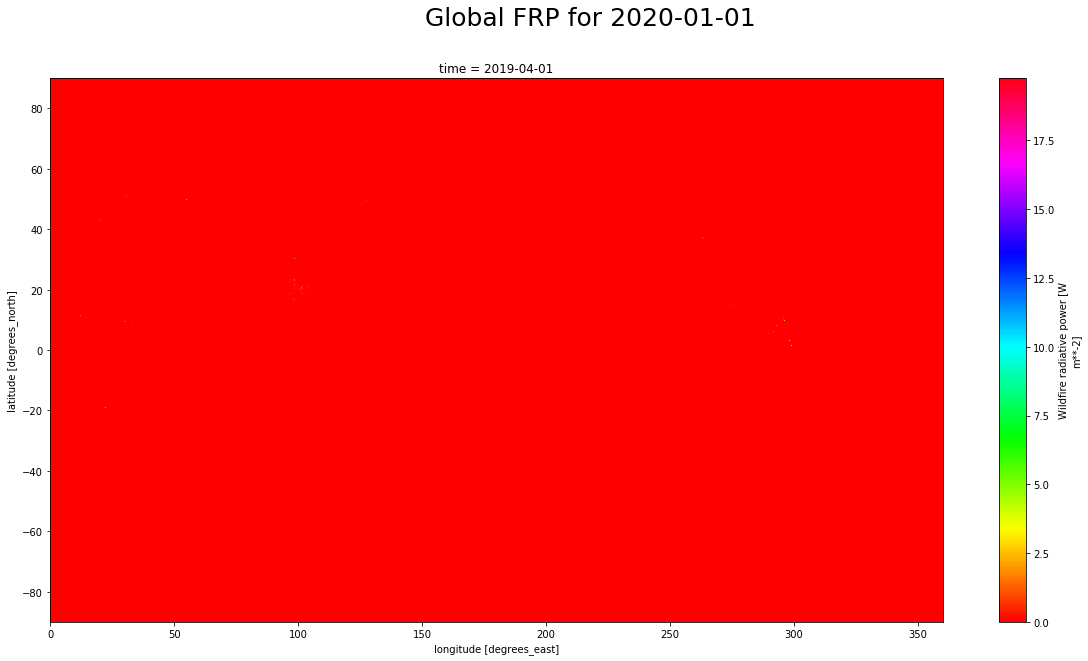

In [100]:
plt.figure(figsize = (20,10)).suptitle('Global FRP for 2020-01-01', fontsize=25)
proc.frpfire[0].plot(cmap='hsv')

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [19]:
np.isnan(proc.frpfire[0].values).any()

False

Printing general stats.

In [27]:
def stats(x):
    tmp = x.mean()
    print('mean', tmp)
    print('mad', abs(x-tmp).mean())
    print('var', x.var())
    print('min', x.min())
    print('max', x.max())

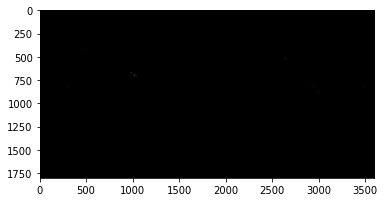

In [206]:
plt.imshow((proc.frpfire.values[0]>0), cmap='gray')

Number of data points with no fire activity (without land water mask):

In [209]:
(proc.frpfire.values==0).sum()/proc.frpfire.values.size*100

74.78297637117993

Percentage of data points with FRP in range `(0, 0.5)` (without land water mask)

In [210]:
((proc.frpfire.values>0)&(proc.frpfire.values<0.5)).sum()/proc.frpfire.values.size*100

0.10213388821426163

In [24]:
stats(proc.frpfire.values)

mean 0.00021382833
mad 0.0004302753
var 0.0012904834002256393
min -7.62939453125e-06
max 186.10562133789062


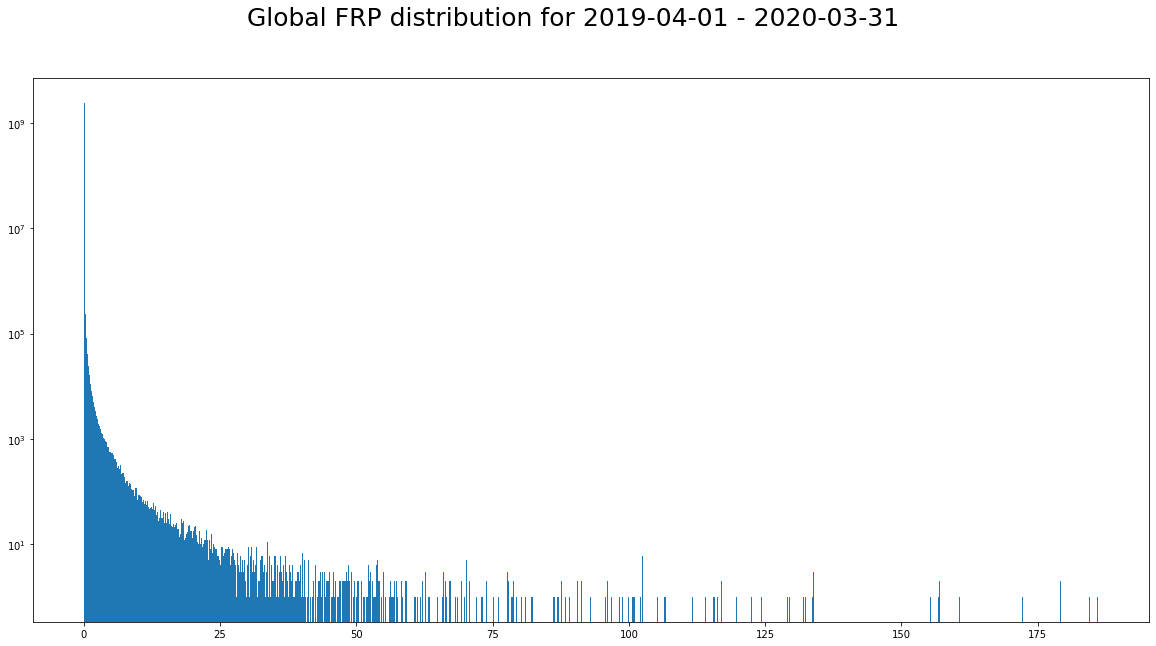

In [123]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values.flatten(), bins=1000, cumulative=False, log=True);

### Applying the mask for water bodies

Obtaining high resolution mask from NaN mask of fwi-forecast.

In [18]:
mask_orig = ~np.isnan(xr.open_dataset('/nvme0/fwi-forecast/ECMWF_FWI_20190130_1200_hr_fwi.nc')['fwi'][0].values)

Resizing the mask to the resolution of gfas-frp

In [19]:
mask_resized = resize(mask_orig, proc.frpfire[0].values.shape) > 0.5

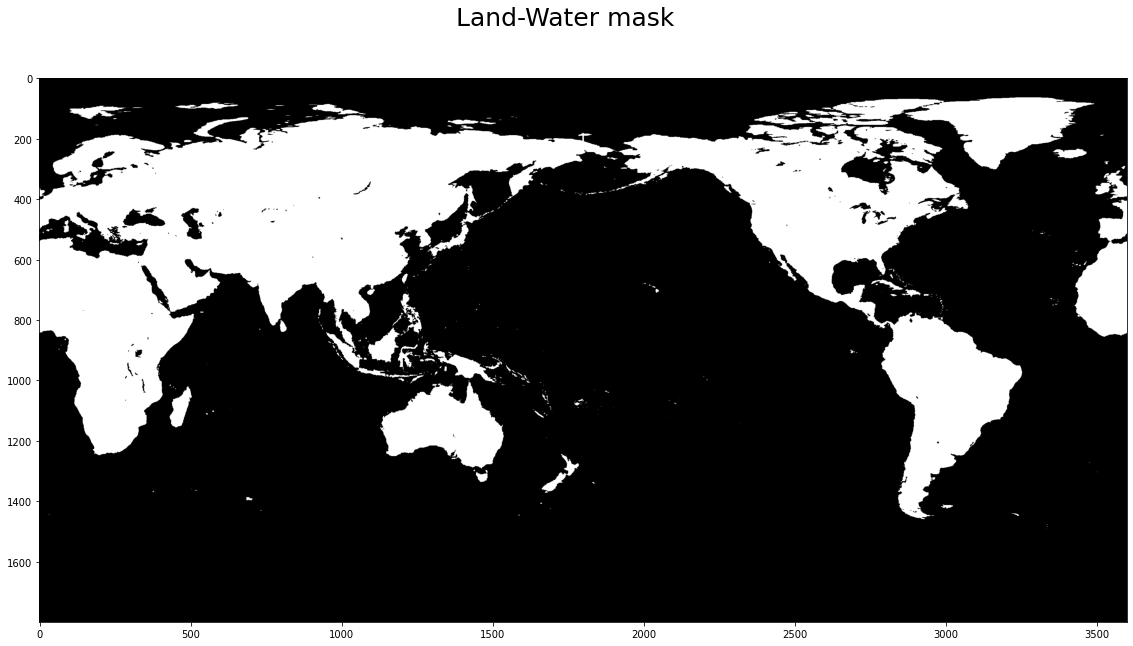

In [314]:
plt.figure(figsize = (20,10)).suptitle('Land-Water mask', fontsize=25)
plt.imshow(mask_resized, cmap='gray');

In [93]:
masked_sample = proc.frpfire[0].values.copy()
masked_sample[mask_resized] = 200

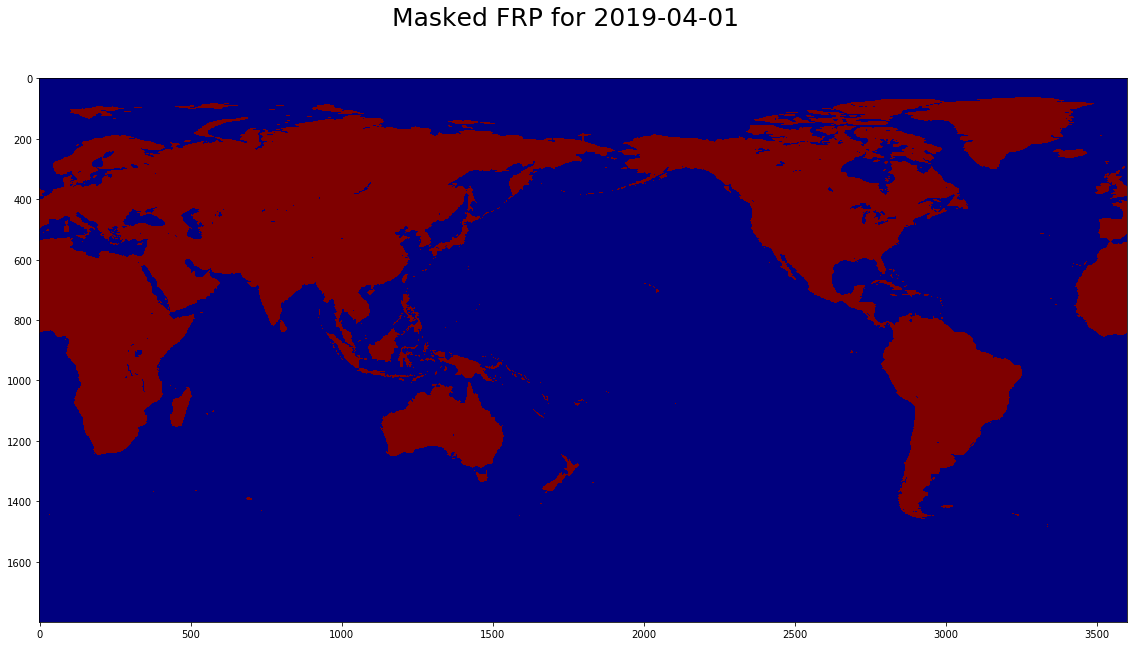

In [124]:
plt.figure(figsize = (20,10)).suptitle('Masked FRP for 2019-04-01', fontsize=25)
plt.imshow(mask_resized, cmap='jet');

In [315]:
np.save('../src/dataloader/mask_frp', mask_resized)

#### Stats for masked FRP

In [213]:
masked_values = proc.frpfire.values[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)]

Number of data points with no fire activity (with land water mask):

In [214]:
(masked_values==0).sum()/masked_values.size*100

74.53714678554985

Percentage of data points with FRP in range `(0, 0.5)` (without land water mask)

In [215]:
((masked_values>0)&(masked_values<0.5)).sum()/masked_values.size*100

0.41540632713372144

In [113]:
stats(masked_values)

mean 0.0008449411
mad 0.0016858313
var 0.0051485044
min -7.6293945e-06
max 186.10562


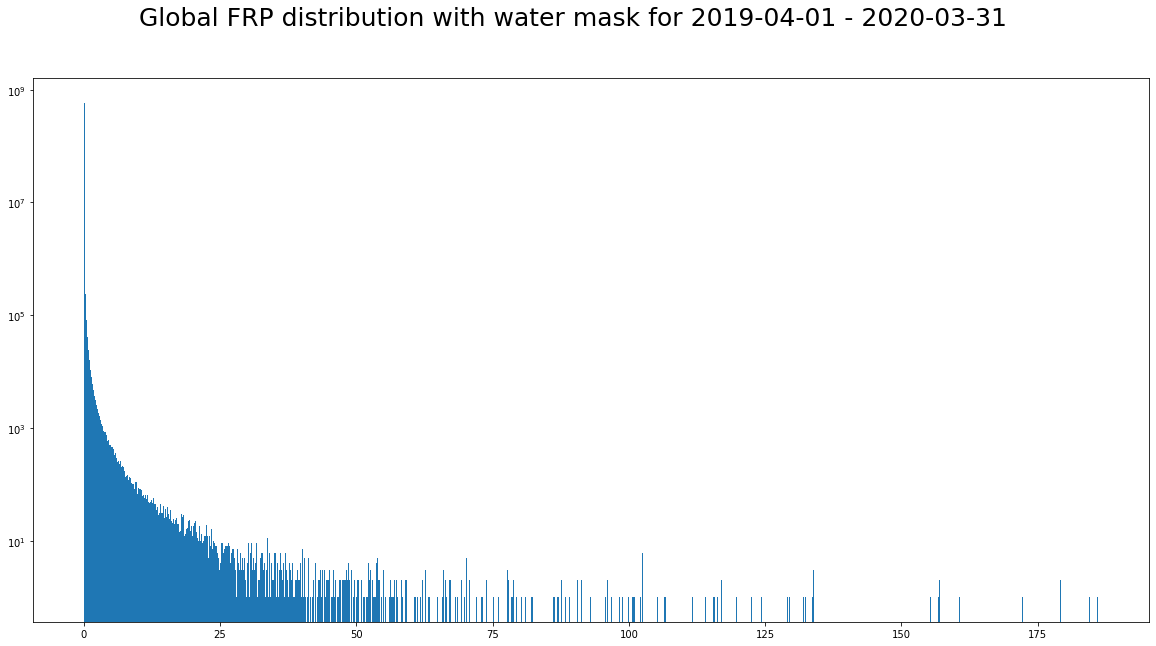

In [8]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution with water mask for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)].flatten(), bins=1000, cumulative=False, log=True);

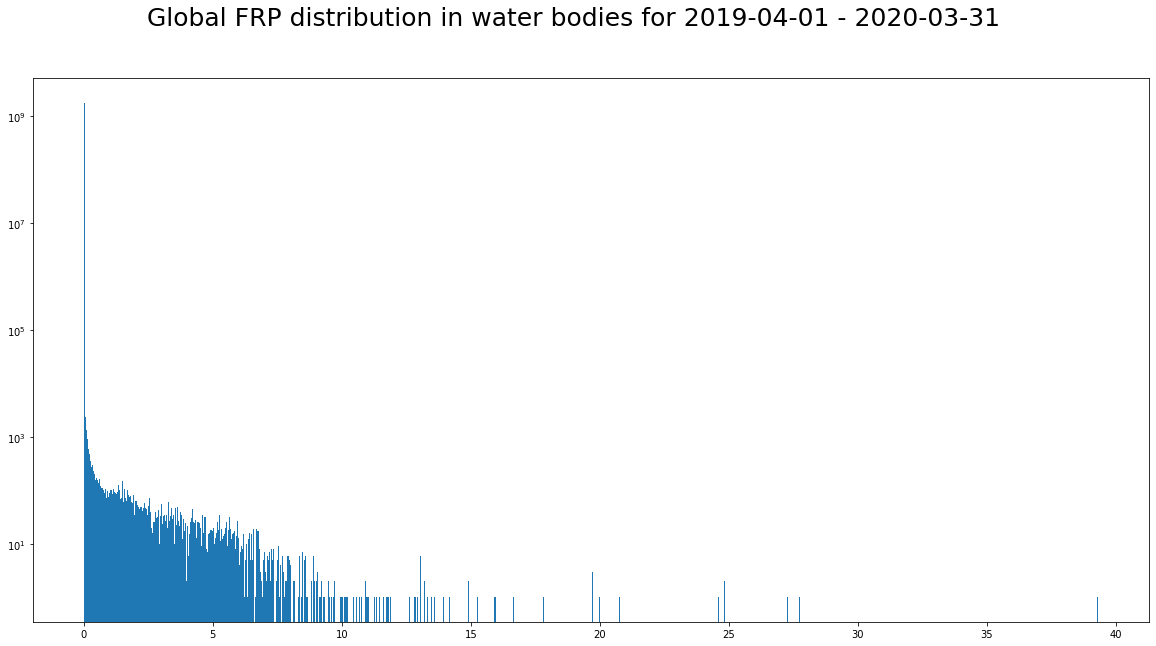

In [9]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution in water bodies for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values[np.broadcast_to(~mask_resized, (366,)+mask_resized.shape)].flatten(), bins=1000, cumulative=False, log=True);

## Negative values in FRP

The negative values are unique and spread throughout the region and timescale.

In [110]:
np.unique(proc.frpfire.values[proc.frpfire.values<0])

array([-7.6293945e-06, -3.8146973e-06], dtype=float32)

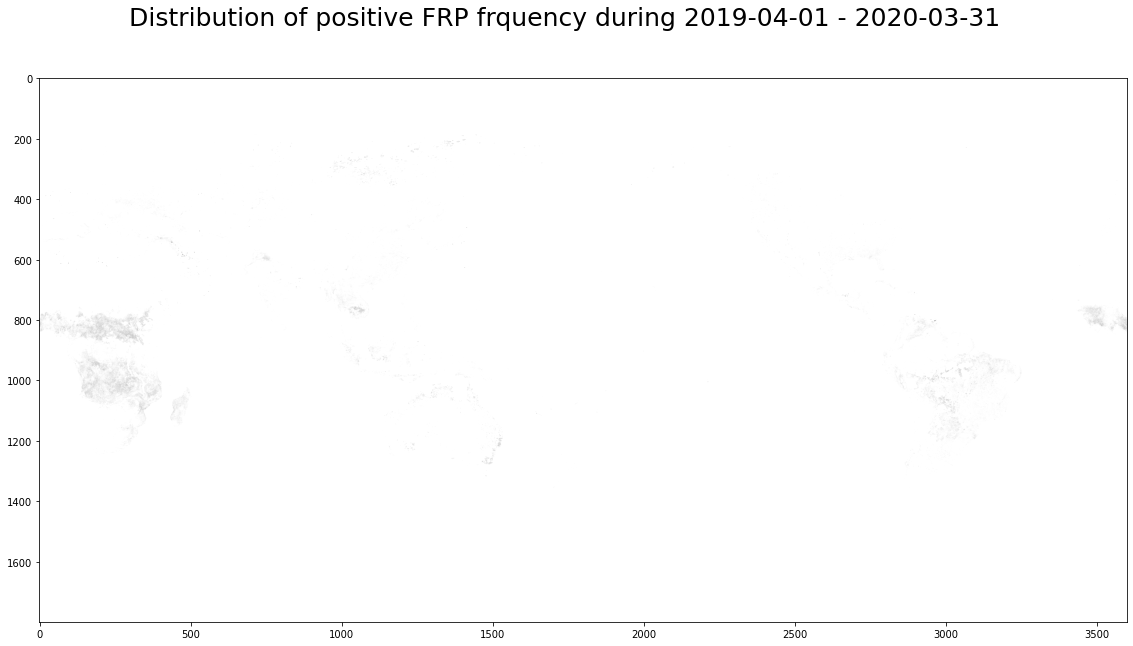

In [122]:
plt.figure(figsize = (20,10)).suptitle('Distribution of positive FRP frequency during 2019-04-01 - 2020-03-31', fontsize=25)
plt.imshow((proc.frpfire.values<0).mean(axis=0), cmap='gray')

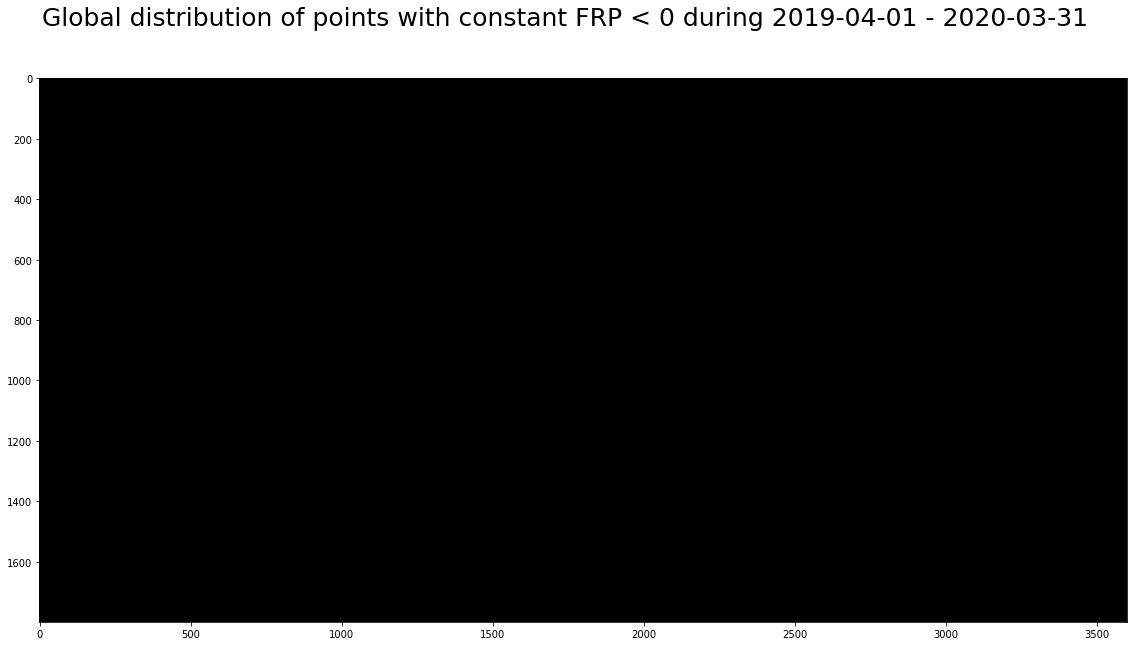

In [121]:
plt.figure(figsize = (20,10)).suptitle('Global distribution of points with constant FRP < 0 during 2019-04-01 - 2020-03-31', fontsize=25)
plt.imshow((proc.frpfire.values<0).sum(axis=0)<0, cmap='gray')

## Transformation

The transformation is done after the following pre-processing:
* Excluding water regions
* Clipping the (0, 0.5) FRP value range to 0.
* Excluding negative values

In [171]:
temp = proc.frpfire.values

In [172]:
temp[(temp>0)&(temp<0.5)] = 1e-10

Percent values falling in (0, 0.5) range

In [181]:
(np.broadcast_to(mask_resized, (366,)+mask_resized.shape)&(temp>0)).sum()/np.broadcast_to(mask_resized, (366,)+mask_resized.shape).size*100

0.006803194360116035

In [193]:
pre_transform = temp[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)&(temp>0)]

In [201]:
stats(pre_transform)

mean 1.754791
mad 1.3919744
var 15.229703
min 0.50021935
max 186.10562


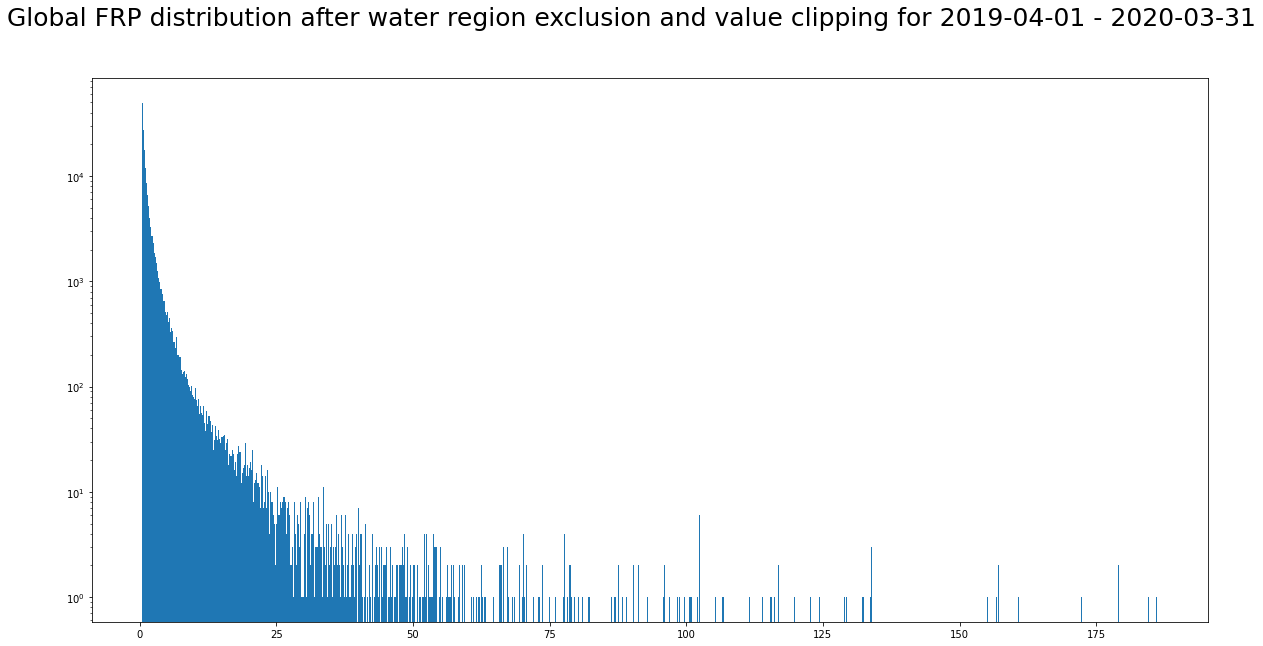

In [194]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution after water region exclusion and value clipping for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(pre_transform.flatten(), bins=1000, cumulative=False, log=True);

### Box-Cox transform

In [195]:
box_cox, lmbda = scipy.stats.boxcox(pre_transform)

In [196]:
lmbda

-0.8397658852658973

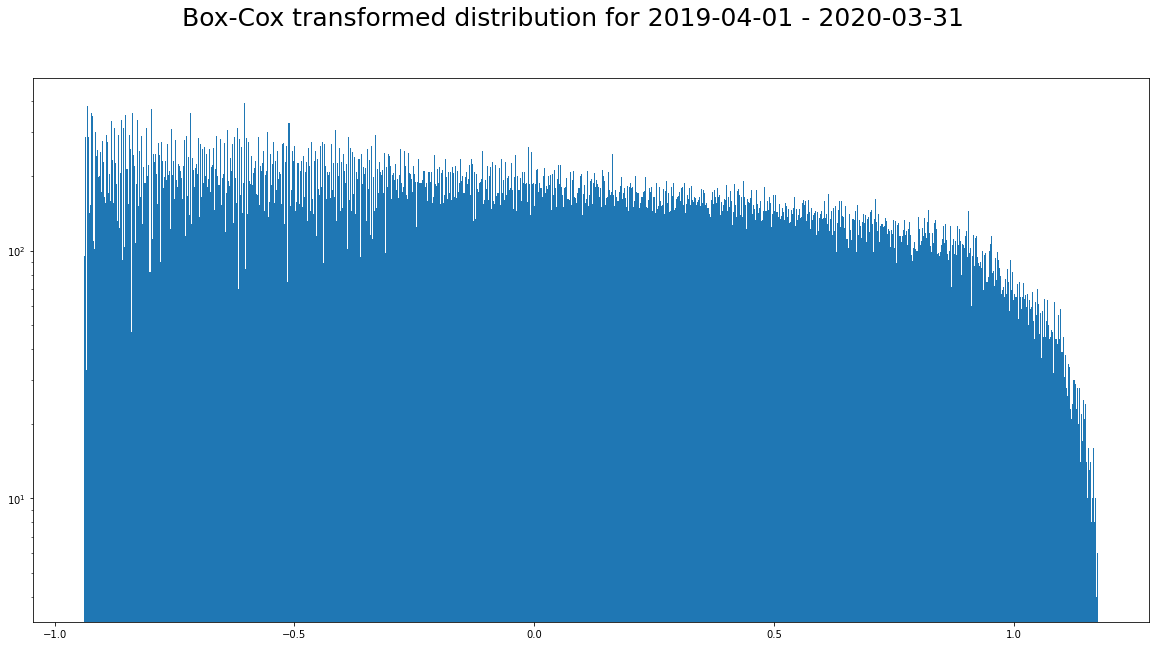

In [197]:
plt.figure(figsize = (20,10)).suptitle('Box-Cox transformed distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(box_cox, bins=1000, cumulative=False, log=True);

In [187]:
stats(box_cox)

mean -0.06211442
mad 0.4730961
var 0.30641195
min -0.9396674
max 1.1760247


### Log transform

In [198]:
log = np.log(pre_transform)

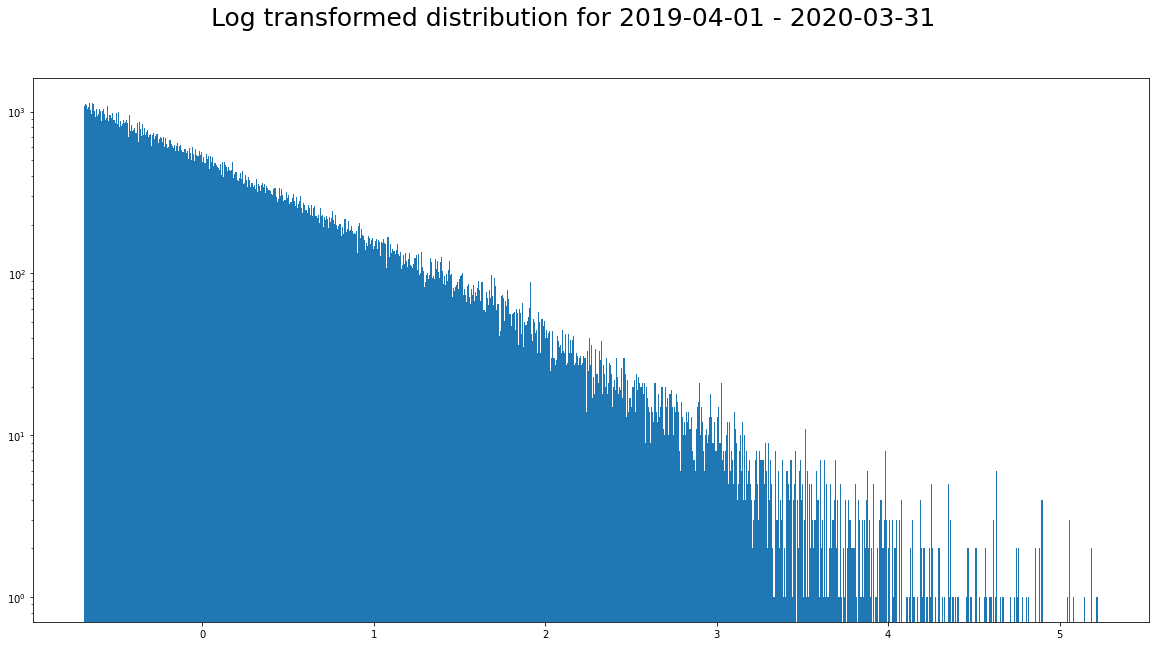

In [199]:
plt.figure(figsize = (20,10)).suptitle('Log transformed distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(log, bins=1000, cumulative=False, log=True);

In [200]:
stats(log)

mean 0.1166933
mad 0.57324064
var 0.56349844
min -0.6927086
max 5.2263145


## Remove isolated fire occurances

Excluding the fire occurances if the FRP for the previous and the next day is zero.

In [20]:
def generate_isolated_mask(x):
    mask = x.copy()
    mask[0] = mask[0]&(x[0]|x[1])
    for i in range(1, 366-1):
        mask[i] = x[i]&(x[i-1]|x[i+1])
    mask[-1] = mask[-1]&x[-2]
    return mask

In [21]:
isolated_mask = generate_isolated_mask(proc.frpfire.values>0)

In [22]:
isolated_water = isolated_mask & mask_resized

Excluding data points with FRP <= 0.5

In [23]:
isolated_water_trimmed = isolated_water & (proc.frpfire.values>0.5)

The values after the above processing derived from Giuseppe et al.

In [24]:
giuseppe_values = proc.frpfire.values[isolated_water_trimmed]

Percent of datapoints remaining before applying isolated datapoints mask

In [302]:
(mask_resized&(proc.frpfire.values>0)).sum()/isolated_water_trimmed.size*100

0.10860242528503003

Percent of datapoints remaining after removing isolated fire incidents

In [303]:
isolated_water_trimmed.sum()/isolated_water_trimmed.size*100

0.006797080550495851

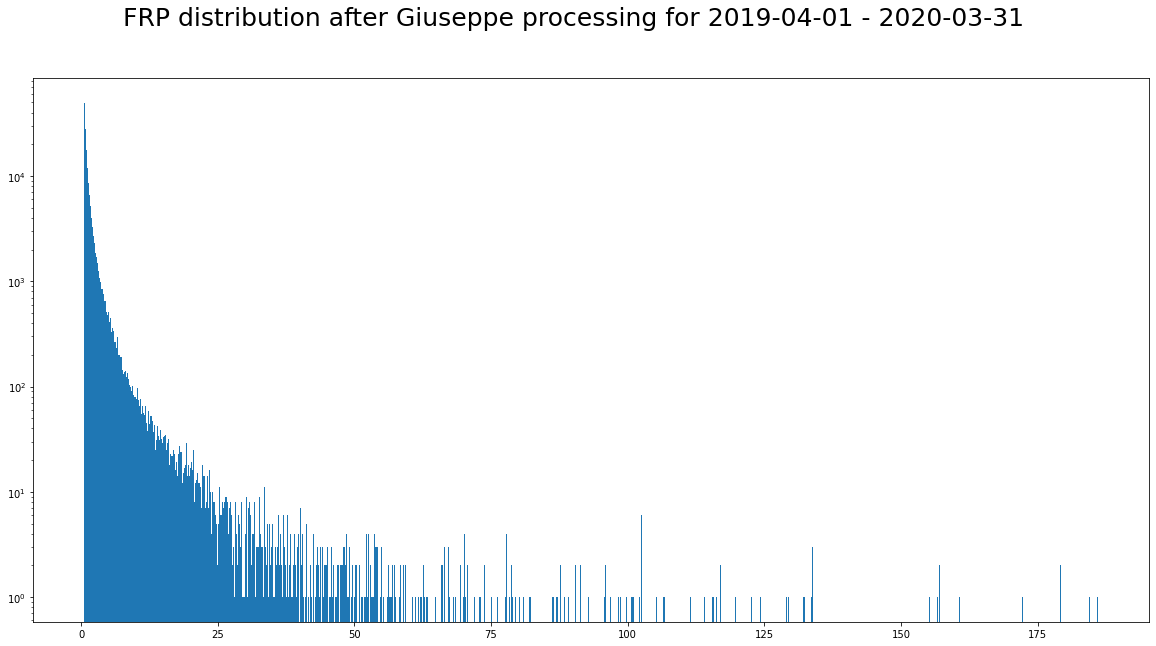

In [304]:
plt.figure(figsize = (20,10)).suptitle('FRP distribution after Giuseppe processing for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(giuseppe_values.flatten(), bins=1000, cumulative=False, log=True);

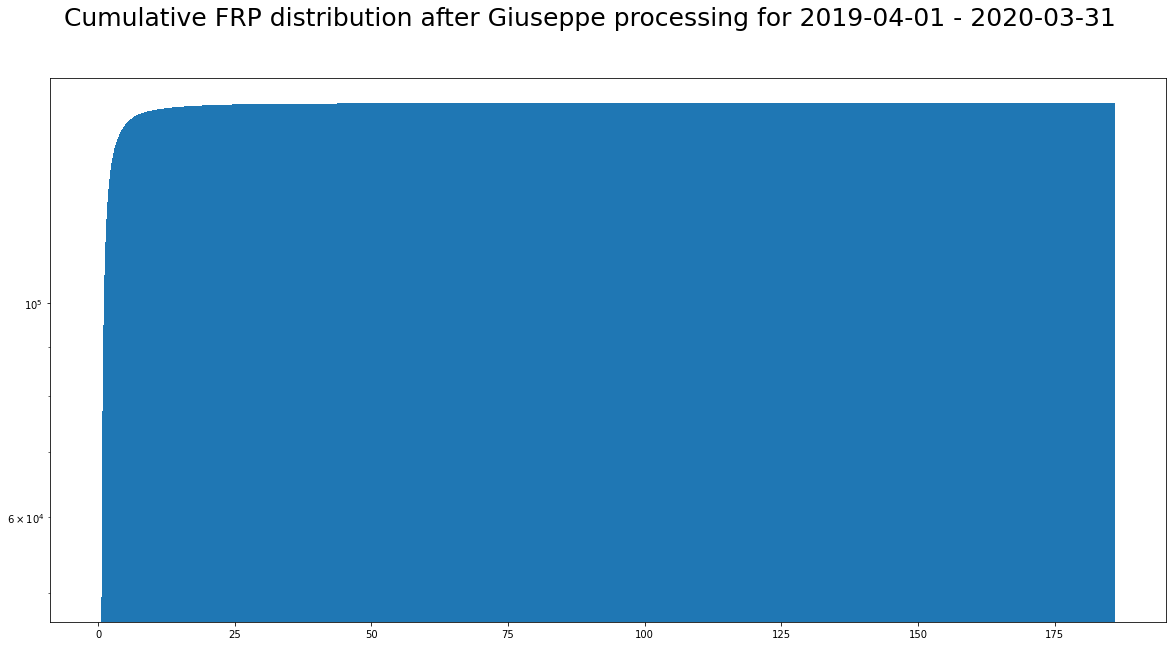

In [276]:
plt.figure(figsize = (20,10)).suptitle('Cumulative FRP distribution after Giuseppe processing for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(giuseppe_values.flatten(), bins=1000, cumulative=True, log=True);

Percentage of data points with FRP > 50

In [306]:
(giuseppe_values>50).sum()/giuseppe_values.size*100

0.10917775503241214

Percentage of data points with FRP > 15

In [305]:
(giuseppe_values>15).sum()/giuseppe_values.size*100

0.9329735430042492

In [28]:
stats(giuseppe_values[giuseppe_values<15])

mean 1.4869117
mad 0.9947449
var 2.7937796
min 0.50021935
max 14.9967575


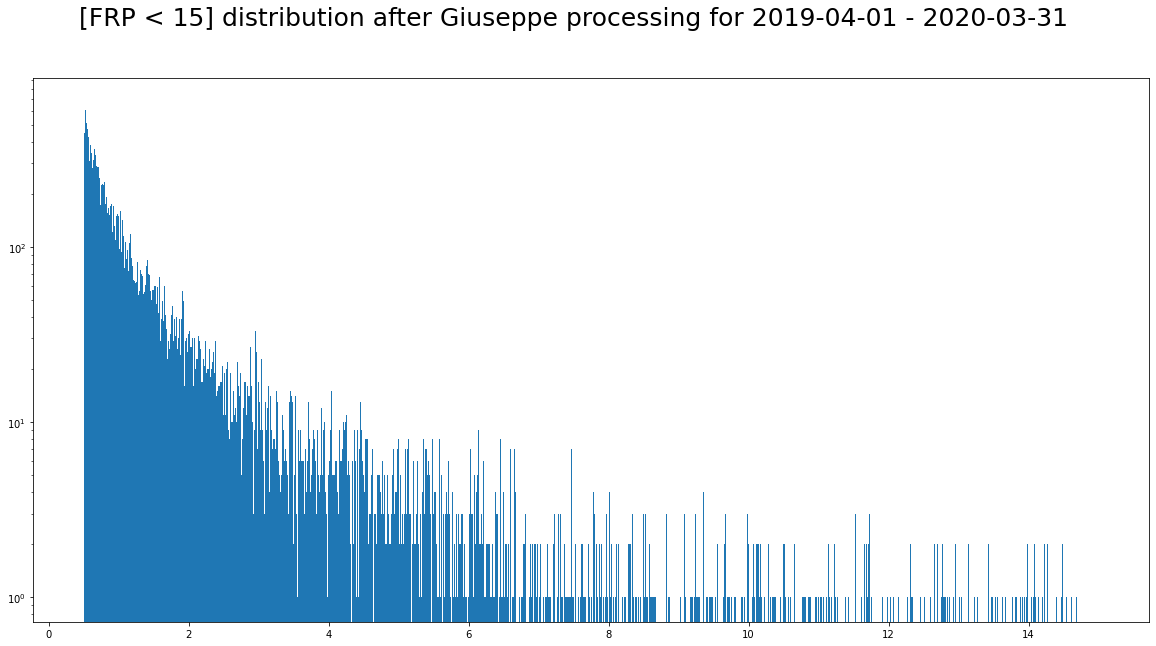

In [25]:
plt.figure(figsize = (20,10)).suptitle('[FRP < 15] distribution after Giuseppe processing for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(giuseppe_values[giuseppe_values<15].flatten(), bins=10000, cumulative=False, log=True);

### Applying box-cox transform

##### Considering the FWI range (0.5, inf)

In [278]:
box_cox, lmbda = scipy.stats.boxcox(giuseppe_values)

In [279]:
lmbda

-0.8397658852658973

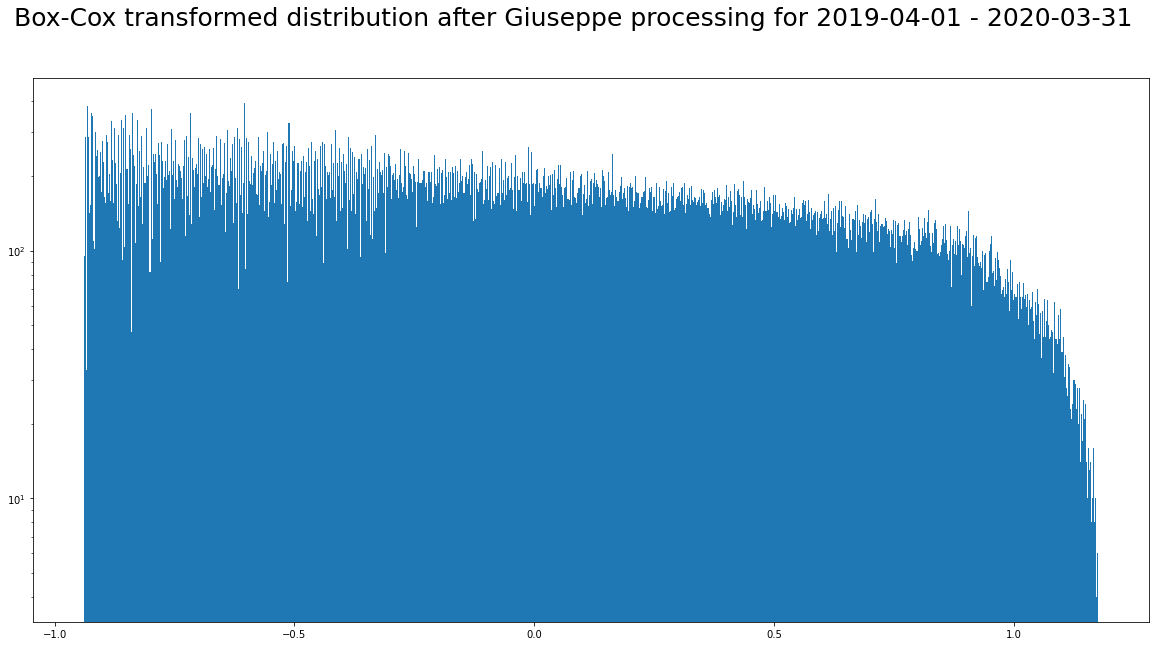

In [280]:
plt.figure(figsize = (20,10)).suptitle('Box-Cox transformed distribution after Giuseppe processing for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(box_cox, bins=1000, cumulative=False, log=True);

##### Considering FWI range (15, inf)

In [307]:
box_cox2, lmbda2 = scipy.stats.boxcox(giuseppe_values[giuseppe_values<15])

In [308]:
stats(box_cox2)

mean -0.07325175
mad 0.465886
var 0.29613134
min -0.940728
max 1.0654808


In [309]:
lmbda2

-0.8427360417396217

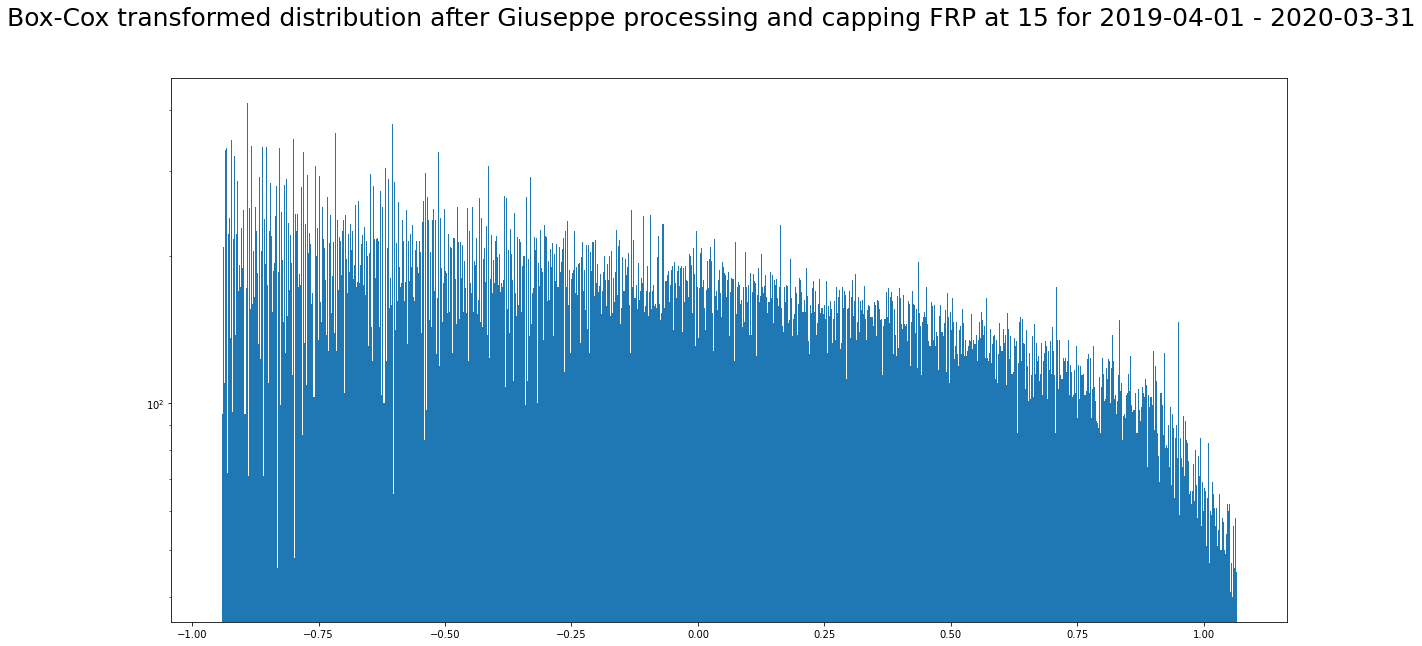

In [310]:
plt.figure(figsize = (20,10)).suptitle('Box-Cox transformed distribution after Giuseppe processing and capping FRP at 15 for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(box_cox2, bins=1000, cumulative=False, log=True);